In [4]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
# Define file paths
model_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\SimCLR_base_models\ohnecontrast_balancedResize_simclr_modelepoch245.pth'
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_10640\88875223.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [18]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):
    #classes = ['explod']
    classes = ['control']  
    #classes = ['single_dose']
    #classes = ['control', 'single_dose','explod']  

    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\kmeans_rank_class\singledose_controls"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'control': 120}


In [19]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [20]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [21]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:03,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:02<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:03<00:02,  1.38it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:05<00:00,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

Batch features shape: torch.Size([8, 512])
Batch labels shape: torch.Size([8])
Features shape after concatenation: torch.Size([120, 512])
Labels shape after concatenation: torch.Size([120])


beforeResize_ex_29 = feats_simclr.tensors[0]
beforeResize_ex_29.shape

beforeResize_sd = feats_simclr.tensors[0]
beforeResize_sd.shape

In [22]:
beforeResize_con = feats_simclr.tensors[0]
beforeResize_con.shape

torch.Size([120, 512])

# Save in the current folder
save_path = "beforeResize_con.pt"  # File name only

# Save the tensor
torch.save(beforeResize_con, save_path)

In [5]:
control = torch.load("beforeResize_con.pt")
sd = torch.load("beforeResize_sd.pt")
ex = torch.load("beforeResize_ex_29.pt")


C:\Users\k54739\AppData\Local\Temp\ipykernel_17652\1227405193.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  control = torch.load("beforeResize_con.pt")
C:\Users\k54739

In [6]:
print(control.shape)
print(sd.shape)
print(ex.shape)


torch.Size([120, 512])
torch.Size([103, 512])
torch.Size([29, 512])


In [22]:
import torch

# Calculate mean and covariance matrix of the sd distribution
sd_mean = torch.mean(sd, dim=0)  # Mean vector of sd
sd_cov = torch.cov(sd.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
sd_cov += torch.eye(sd_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
sd_cov_inv = torch.linalg.inv(sd_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in control]
ex_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in ex]
sd_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in sd]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([ 5693.4268,  7197.2632,  5690.1396,  4432.7788,  6081.2715,  7113.1777,
         8004.1353,  9189.9277,  7095.2656,  9916.8320,  9082.3193,  5248.9585,
         5669.0811,  6782.2671,  6191.3755,  7989.4390,  6867.5923,  5824.6230,
         6826.4038,  6578.9839,  8282.9053,  6993.2148,  5750.5308,  6661.1196,
         4978.7285,  7768.5942,  7689.0044,  6569.9116,  7605.3018,  7146.1841,
         7455.0166,  8259.3145,  7431.3672, 10933.7891,  6818.3516,  8759.3457,
         6153.5464,  5495.2173,  4584.2358,  7164.4209,  5403.9395,  8568.3701,
         7735.0156,  9264.4238,  6167.1279,  6412.6431,  7485.8408,  5894.3652,
         6771.1675,  6751.1733,  7067.4868,  5224.7495,  5375.5303,  8558.5615,
         5840.9028,  6560.4390,  7173.2695,  5963.8887,  6600.6445,  6551.6050,
         6557.9785,  7104.8105,  4055.8123,  6066.5522,  6891.8540,  6996.2764,
         8457.7471,  7375.8608,  6553.7827,  7432.4771,  7527.9795,  4556.9341,
         7622.8315,  

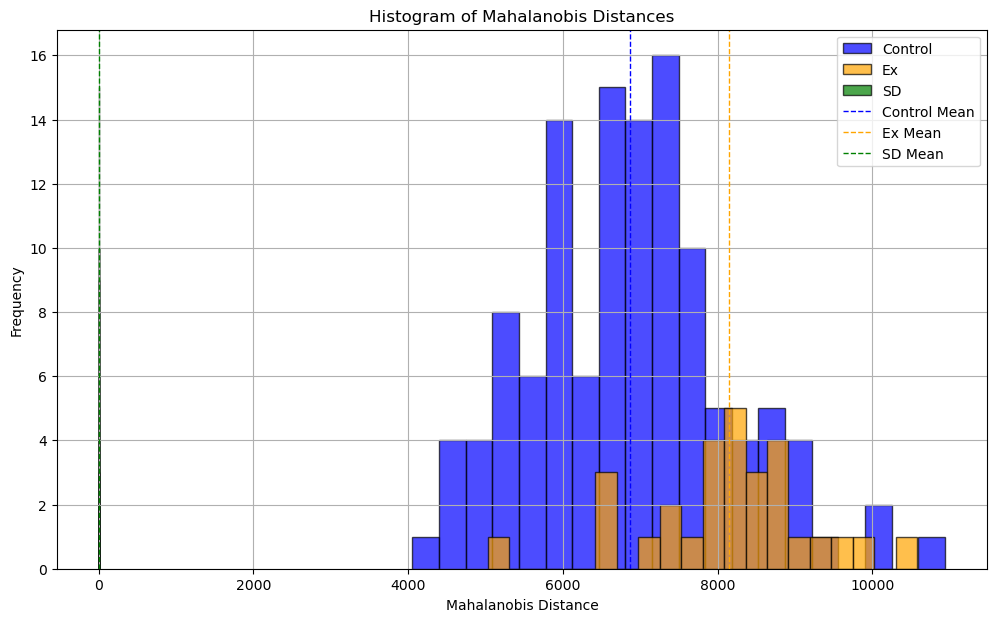

C:\Users\k54739\AppData\Local\Temp\ipykernel_8352\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


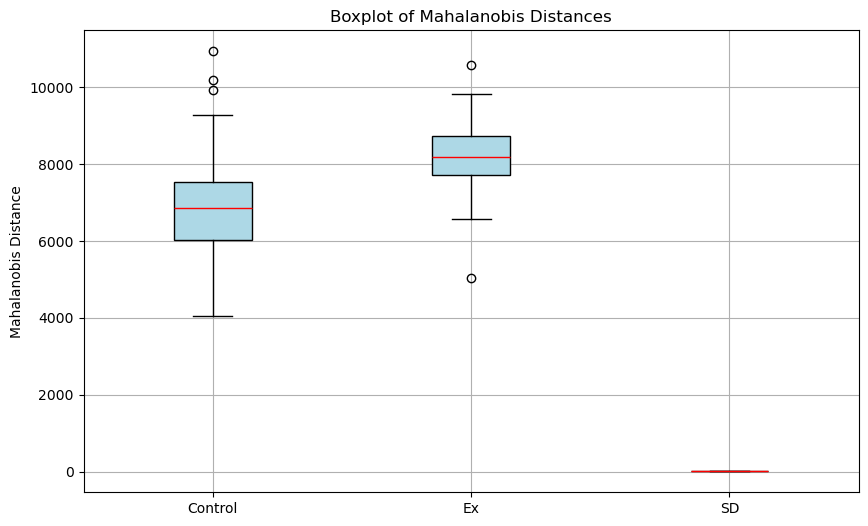

In [23]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


import torch

# Calculate mean and covariance matrix of the sd distribution
sd_mean = torch.mean(sd, dim=0)  # Mean vector of sd
sd_cov = torch.cov(sd.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5  # Same regularization constant as your second code
sd_cov += torch.eye(sd_cov.size(0)) * epsilon

# Inverse covariance matrix
sd_cov_inv = torch.linalg.inv(sd_cov)

# Function to calculate Mahalanobis distance (vectorized)
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    # Using vectorized form
    distance = torch.sqrt(torch.dot(diff.flatten(), torch.matmul(cov_inv, diff.flatten())))
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in control]
ex_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in ex]
sd_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in sd]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)


import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


In [28]:
import torch

# Calculate mean and covariance matrix of the sd distribution
ex_mean = torch.mean(ex, dim=0)  # Mean vector of sd
ex_cov = torch.cov(ex.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
ex_cov += torch.eye(ex_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
ex_cov_inv = torch.linalg.inv(ex_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, ex_mean, ex_cov_inv) for vec in control]
ex_distances = [mahalanobis_distance(vec, ex_mean, ex_cov_inv) for vec in ex]
sd_distances = [mahalanobis_distance(vec, ex_mean, ex_cov_inv) for vec in sd]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([ 7980.2651,  7870.0913,  8291.7412,  6508.4590,  7799.8271,  8398.1172,
         7999.8345, 12065.9248,  8569.5762, 12822.5303, 12378.3145,  9116.6709,
         6652.4756,  8099.2153, 12187.5762,  9018.9121, 10027.0703,  7622.5205,
         8725.4961,  7415.9023,  9769.3223,  9840.2500, 10147.5381, 10107.5098,
         7841.6377,  7593.3867, 10247.1025,  9748.0498,  9001.4805,  9322.5010,
         9396.5088, 10600.5254,  8246.8984, 11765.3887,  8021.3950,  9482.3564,
         7091.8892,  9648.6895,  9059.0137,  9958.8730,  7213.3735, 11297.7627,
         9869.5908, 13038.0303,  8564.6611,  8884.4404,  8770.1592,  7918.4312,
         7700.1216,  7846.8970,  8287.9229,  9419.5645, 11970.1162, 10363.1201,
        10154.8770, 10455.3447,  7909.1484, 11052.2588,  8657.5469,  8513.6514,
         7279.4414,  9196.9990, 10311.0078,  8610.4131,  9052.4219,  8665.8926,
        11310.7188,  7348.1045,  9541.2832,  8554.7607,  8002.8237,  6761.9180,
         9018.9102,  

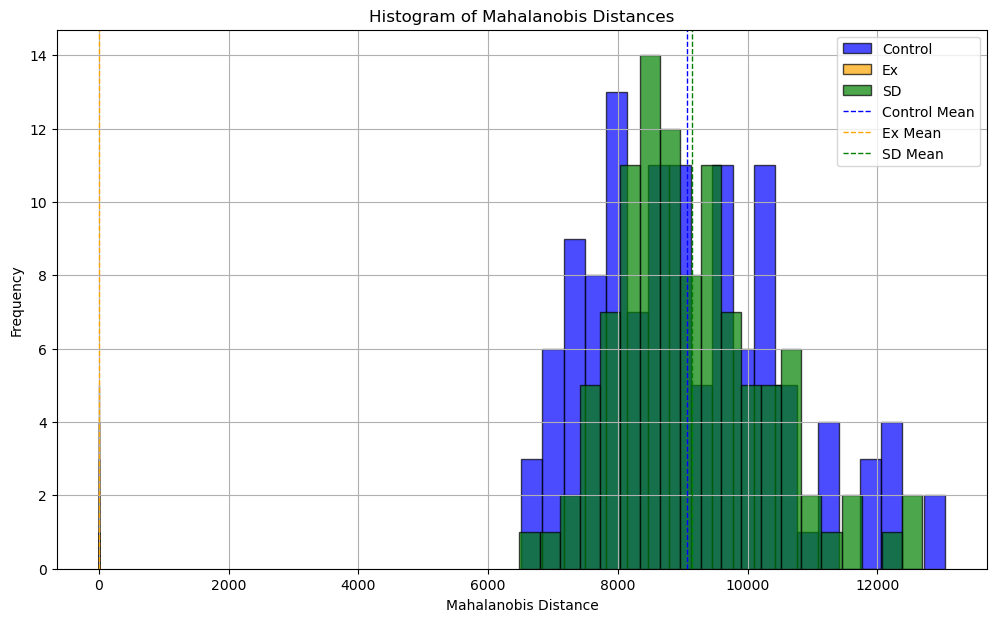

C:\Users\k54739\AppData\Local\Temp\ipykernel_8352\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


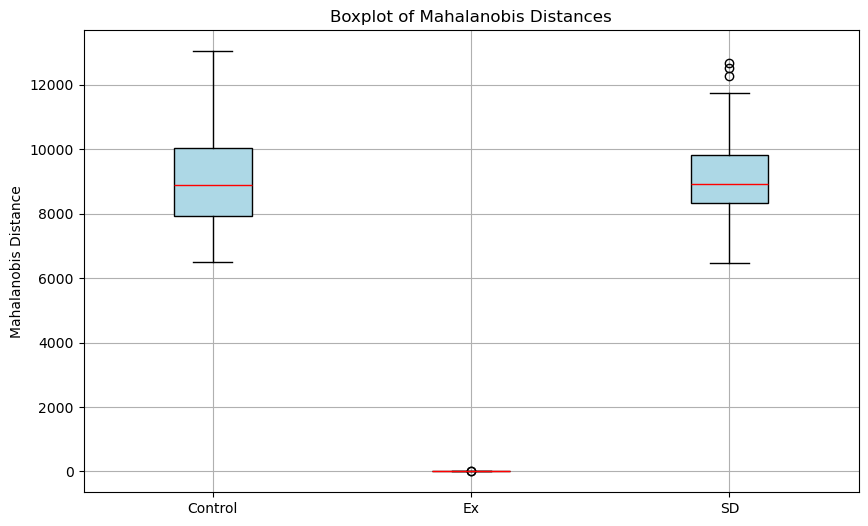

In [29]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


In [30]:
import torch

# Calculate mean and covariance matrix of the sd distribution
con_mean = torch.mean(control, dim=0)  # Mean vector of sd
con_cov = torch.cov(control.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
con_cov += torch.eye(con_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
con_cov_inv = torch.linalg.inv(con_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in control]
ex_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in ex]
sd_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in sd]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([10.8136, 10.8351, 10.7690, 10.9650, 10.8515, 10.8347, 10.9906, 10.8293,
        10.9041, 10.7972, 10.8694, 10.8249, 10.9081, 10.7730, 10.7938, 10.9037,
        10.7827, 10.8398, 10.9077, 10.8848, 10.8921, 10.7409, 10.8335, 10.9023,
        10.8087, 10.9215, 10.7970, 10.8198, 10.8648, 10.9595, 10.8588, 10.9329,
        10.8537, 10.7897, 10.8681, 10.9004, 10.8641, 10.8500, 10.9190, 10.8377,
        10.8513, 10.9475, 10.9288, 10.8778, 10.8915, 10.8677, 10.8660, 10.8593,
        10.8572, 10.8109, 10.7821, 10.8588, 10.8743, 10.8519, 10.7913, 10.9446,
        10.8729, 10.9344, 10.9560, 10.8690, 10.9554, 10.9482, 10.8718, 10.8950,
        10.8581, 10.8577, 10.8812, 10.9417, 10.8143, 10.8914, 10.9048, 10.8603,
        10.8164, 10.8512, 10.7938, 10.8964, 10.8916, 10.8324, 10.7611, 10.8643,
        10.9405, 10.7992, 10.9489, 10.8710, 10.8035, 10.8751, 10.9555, 10.8251,
        10.8026, 10.8860, 10.8501, 10.7946, 10.8911, 10.8622, 10.9024, 10.8542,
        10.8264, 10.8

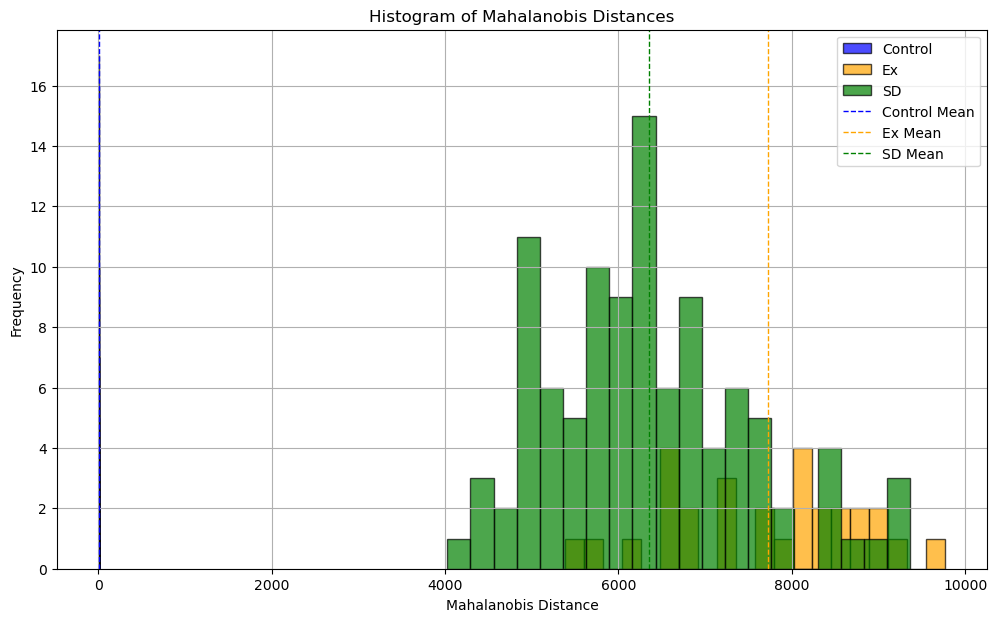

C:\Users\k54739\AppData\Local\Temp\ipykernel_8352\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


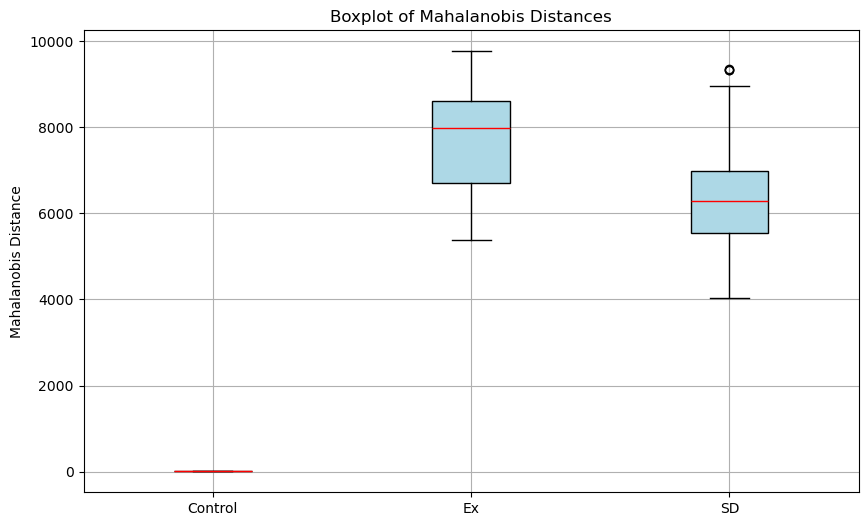

In [31]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


In [1]:
# scaled

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sd_scaled = scaler.fit_transform(sd)
control_scaled = scaler.transform(control)
ex_scaled = scaler.transform(ex)

# Convert the scaled numpy arrays to torch tensors
sd_scaled = torch.tensor(sd_scaled, dtype=torch.float32)
control_scaled = torch.tensor(control_scaled, dtype=torch.float32)
ex_scaled = torch.tensor(ex_scaled, dtype=torch.float32)


In [26]:
import torch

# Calculate mean and covariance matrix of the sd distribution
sd_mean = torch.mean(sd_scaled, dim=0)  # Mean vector of sd
sd_cov = torch.cov(sd_scaled.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
sd_cov += torch.eye(sd_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
sd_cov_inv = torch.linalg.inv(sd_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in control_scaled]
ex_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in ex_scaled]
sd_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in sd_scaled]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([  2594.4150,   3334.5649,   2516.9412,   2301.5205,   2995.5173,
          3018.5066,  25679.8652,   4655.4971,  26211.5430,   5274.7866,
          3778.3518,   2381.2139,  21026.0820,  39474.0781,   2517.8591,
          8936.1768,   2701.8210,  14073.1699,   3384.2698,  20293.9375,
          5711.7480,   3385.1958,   2128.2063,   2915.7146,   1971.0994,
        103850.6172,   3942.3286,   2908.3750,   8255.3652,   4060.1685,
          3636.9375,   4437.7852,   4905.5581,  77418.4297,  60757.3516,
         29182.8594,   2554.6091,   1881.6298,   1715.2277,   2983.8110,
          2502.3975,   3647.2927,   3578.8618,   4088.3545,   2858.4243,
          2560.8330,  61236.6680,   2650.6548,  14317.1387,  35754.4922,
         58433.8906,   1968.0187,   2211.0435,   7556.2334,   2059.5520,
          2978.2856,   4001.8799,   2296.3203,   3750.0750,   2847.4460,
        110719.2500,   3324.7378,   1278.2257,  21416.6660,   3019.0286,
          5499.5181,   3358.2363

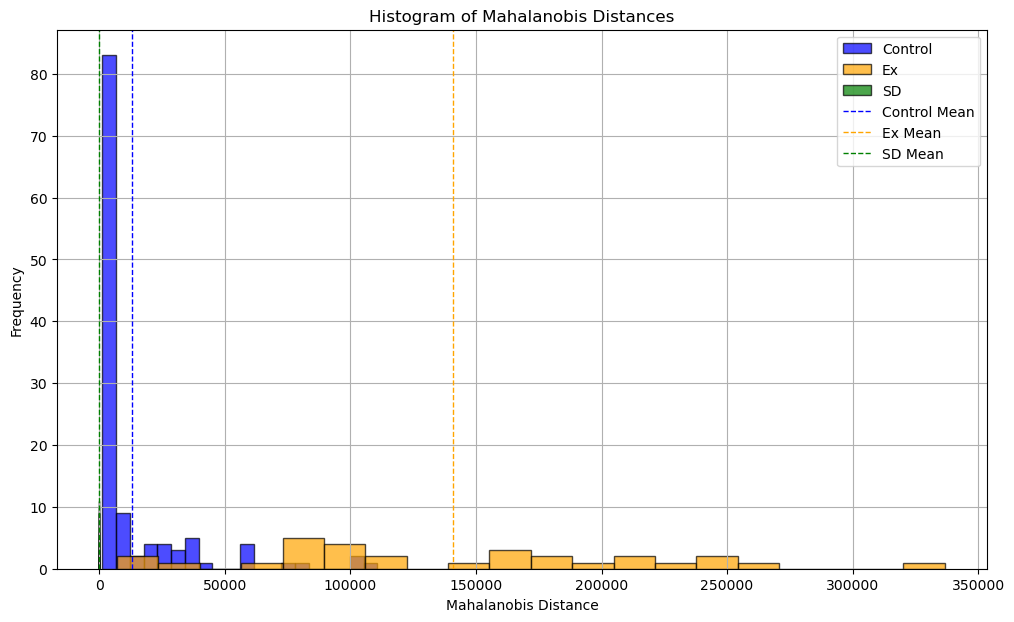

C:\Users\k54739\AppData\Local\Temp\ipykernel_17652\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


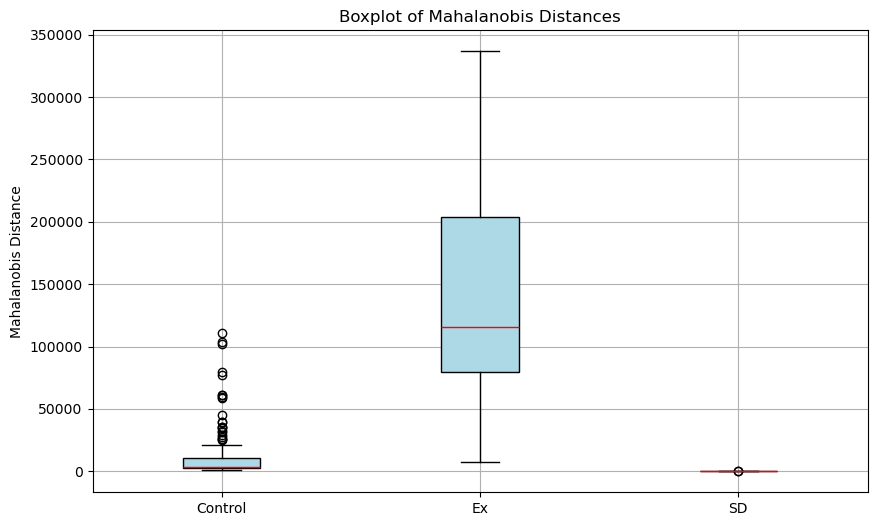

In [27]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


In [20]:
# control fixed

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
control_scaled = scaler.fit_transform(control)
sd_scaled = scaler.transform(sd)
ex_scaled = scaler.transform(ex)

# Convert the scaled numpy arrays to torch tensors
sd_scaled = torch.tensor(sd_scaled, dtype=torch.float32)
control_scaled = torch.tensor(control_scaled, dtype=torch.float32)
ex_scaled = torch.tensor(ex_scaled, dtype=torch.float32)


In [23]:
import torch

# Calculate mean and covariance matrix of the sd distribution
con_mean = torch.mean(control_scaled, dim=0)  # Mean vector of sd
con_cov = torch.cov(control_scaled.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
con_cov += torch.eye(con_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
con_cov_inv = torch.linalg.inv(con_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in control_scaled]
ex_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in ex_scaled]
sd_distances = [mahalanobis_distance(vec, con_mean, con_cov_inv) for vec in sd_scaled]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([10.8522, 10.8567, 10.8577, 10.8586, 10.8492, 10.8569, 10.8571, 10.8492,
        10.8566, 10.8580, 10.8534, 10.8604, 10.8582, 10.8613, 10.8631, 10.8599,
        10.8595, 10.8543, 10.8477, 10.8600, 10.8548, 10.8605, 10.8605, 10.8593,
        10.8601, 10.8590, 10.8587, 10.8605, 10.8574, 10.8555, 10.8552, 10.8534,
        10.8500, 10.8593, 10.8552, 10.8477, 10.8611, 10.8619, 10.8645, 10.8534,
        10.8586, 10.8549, 10.8555, 10.8606, 10.8599, 10.8565, 10.8613, 10.8563,
        10.8514, 10.8593, 10.8607, 10.8633, 10.8629, 10.8546, 10.8615, 10.8614,
        10.8606, 10.8605, 10.8610, 10.8549, 10.8600, 10.8499, 10.8680, 10.8599,
        10.8501, 10.8637, 10.8589, 10.8598, 10.8586, 10.8551, 10.8564, 10.8602,
        10.8559, 10.8551, 10.8594, 10.8579, 10.8455, 10.8590, 10.8585, 10.8570,
        10.8580, 10.8665, 10.8597, 10.8579, 10.8558, 10.8628, 10.8569, 10.8603,
        10.8612, 10.8532, 10.8547, 10.8571, 10.8597, 10.8598, 10.8616, 10.8570,
        10.8641, 10.8

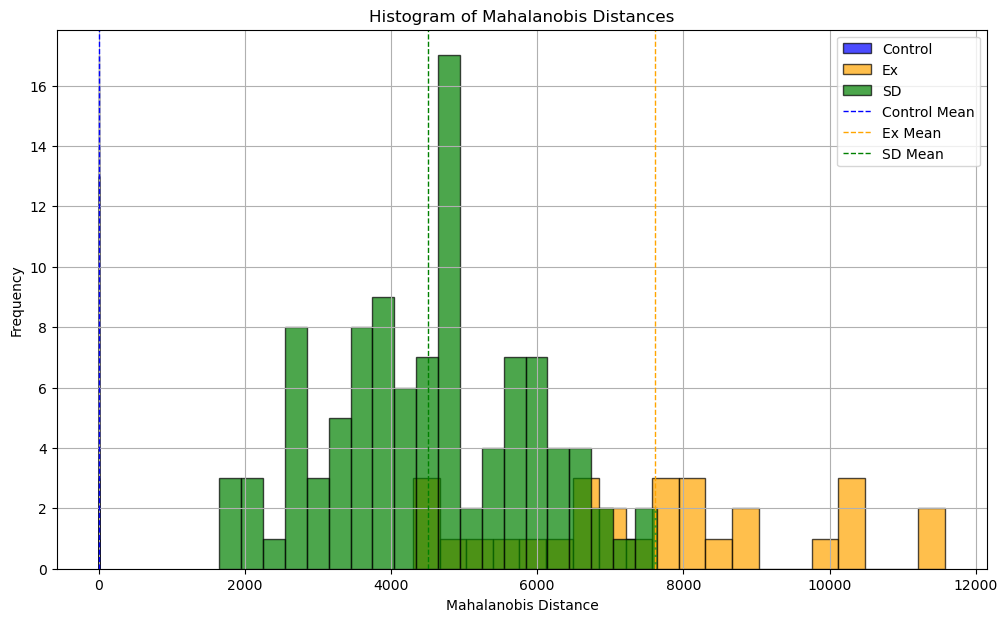

C:\Users\k54739\AppData\Local\Temp\ipykernel_17652\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


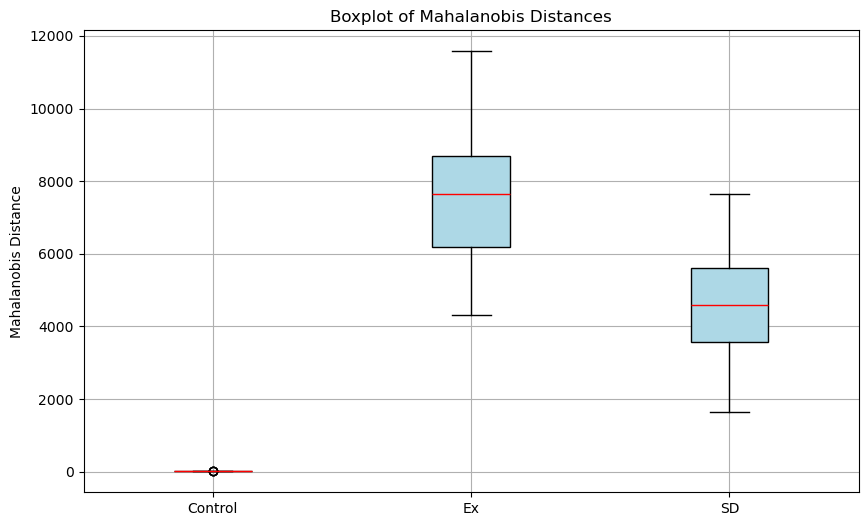

In [24]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()


In [19]:
# std scaler

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sd_scaled = scaler.fit_transform(sd)
control_scaled = scaler.transform(control)
ex_scaled = scaler.transform(ex)


In [15]:
# Convert the scaled numpy arrays to torch tensors
sd_scaled = torch.tensor(sd_scaled, dtype=torch.float32)
control_scaled = torch.tensor(control_scaled, dtype=torch.float32)
ex_scaled = torch.tensor(ex_scaled, dtype=torch.float32)

In [16]:
import torch

# Calculate mean and covariance matrix of the sd distribution
sd_mean = torch.mean(sd_scaled, dim=0)  # Mean vector of sd
sd_cov = torch.cov(sd_scaled.T)         # Covariance matrix of sd

# Regularize the covariance matrix
epsilon = 1e-5
sd_cov += torch.eye(sd_cov.size(0)) * epsilon

# Calculate the inverse of the covariance matrix
sd_cov_inv = torch.linalg.inv(sd_cov)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(vec, mean, cov_inv):
    diff = vec - mean
    result = torch.mm(torch.mm(diff.unsqueeze(0), cov_inv), diff.unsqueeze(1))
    if result.item() < 0:  # Debugging for negative values
        print(f"Negative value detected: {result.item()}")
    distance = torch.sqrt(result)
    return distance.item()  # Convert to scalar value

# Calculate distances for control and ex
control_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in control_scaled]
ex_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in ex_scaled]
sd_distances = [mahalanobis_distance(vec, sd_mean, sd_cov_inv) for vec in sd_scaled]

# Convert distances to tensors for further analysis if needed
control_distances = torch.tensor(control_distances)
ex_distances = torch.tensor(ex_distances)
sd_distance = torch.tensor(sd_distances)

# Print results
print("Control distances:", control_distances)
print("Ex distances:", ex_distances)
print("sd distances:", sd_distance)



Control distances: tensor([ 13725.4785,  17838.6035,  13290.6484,  13927.7129,  16355.0947,
         15708.7822, 212747.2188,  25576.5820, 216967.0625,  29864.0176,
         19084.6680,  12569.4316, 174649.1094, 328988.5625,  12707.6133,
         69327.3125,  14066.4990, 115561.7109,  17902.4629, 167978.9531,
         39377.7188,  17906.6973,  10623.2783,  15505.3984,   9891.5674,
        865989.2500,  24397.0430,  15250.0703,  64466.4922,  24983.8828,
         19038.0781,  24262.7383,  35659.6562, 644453.6875, 506073.2188,
        241645.0469,  13210.2012,   9399.1816,   8352.3994,  14992.2578,
         13555.9766,  18331.4785,  18645.2090,  20799.1055,  15262.7236,
         13041.3584, 510178.9688,  13708.2021, 117152.5547, 297119.2812,
        486933.7188,   9625.8623,  10829.1582,  57809.8320,  10495.9277,
         15864.2803,  26675.8418,  11552.2539,  22461.3750,  15127.7773,
        923194.4375,  17331.6348,   5907.3296, 177618.3906,  15667.3867,
         41328.8164,  17004.1699

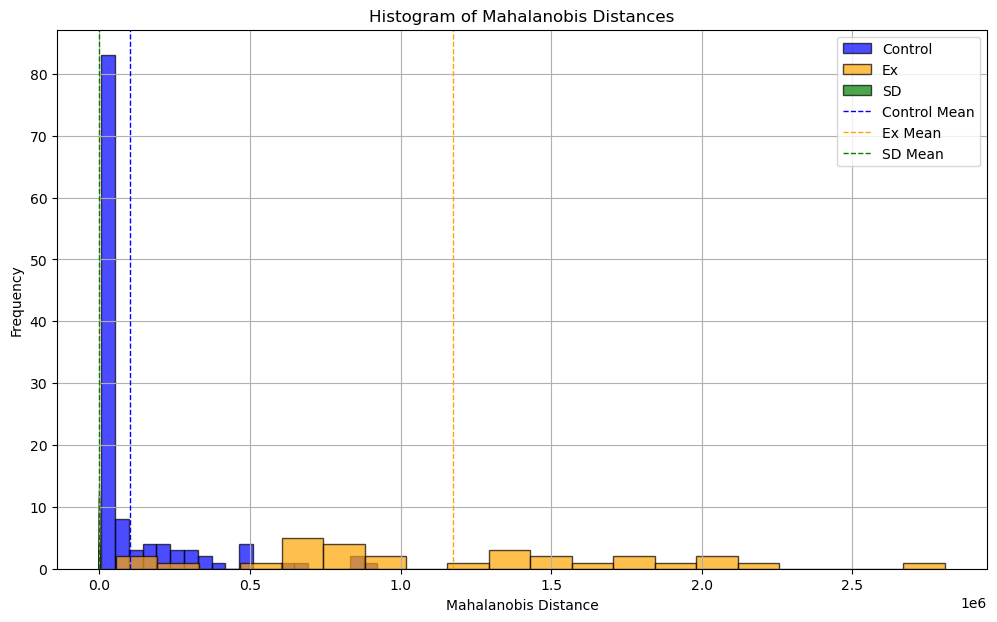

C:\Users\k54739\AppData\Local\Temp\ipykernel_17652\3030954929.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,


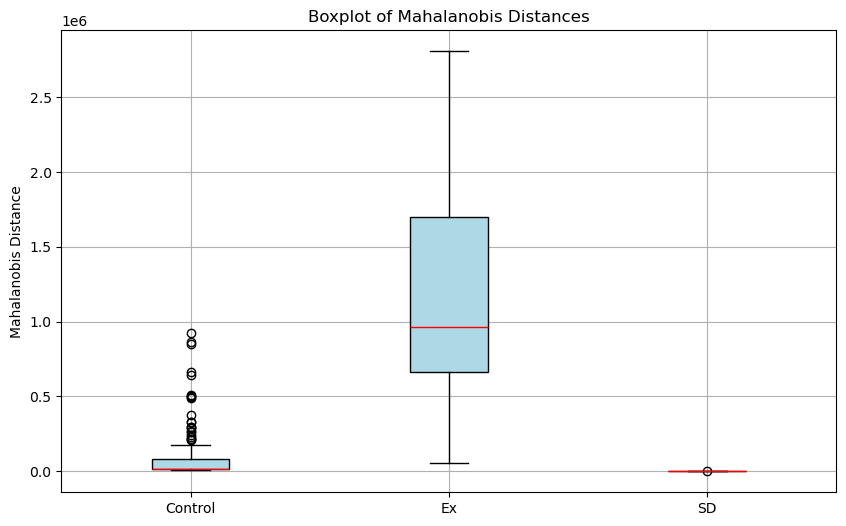

In [17]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays for plotting
control_distances = control_distances.numpy()
ex_distances = ex_distances.numpy()
sd_distances = sd_distance.numpy()

# Create a histogram
plt.figure(figsize=(12, 7))
plt.hist(control_distances, bins=20, alpha=0.7, label='Control', color='blue', edgecolor='black')
plt.hist(ex_distances, bins=20, alpha=0.7, label='Ex', color='orange', edgecolor='black')
plt.hist(sd_distances, bins=20, alpha=0.7, label='SD', color='green', edgecolor='black')

plt.axvline(x=control_distances.mean(), color='blue', linestyle='dashed', linewidth=1, label='Control Mean')
plt.axvline(x=ex_distances.mean(), color='orange', linestyle='dashed', linewidth=1, label='Ex Mean')
plt.axvline(x=sd_distances.mean(), color='green', linestyle='dashed', linewidth=1, label='SD Mean')

plt.title('Histogram of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([control_distances, ex_distances, sd_distances], labels=['Control', 'Ex', 'SD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Boxplot of Mahalanobis Distances')
plt.ylabel('Mahalanobis Distance')
plt.grid()
plt.show()
